In [1]:
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import math
from glob import glob
from pathlib import Path
import os

import numpy as np
import scipy
import scipy.io # matlab

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.utils.data as data  # dataset shuffling, sample batching, ...
from torch import nn  # neural network layers
import torchvision.transforms as T  # augmentation

%matplotlib inline
imginfo = lambda img: print(type(img), img.dtype, img.shape, img.min(), img.max())


@dataclass
class Args:
    data_dir: str = "./data"
    brain_region: str = "rfa" # load cfa or rfa brain region
    subsample_length: int = 50 # signal subsampling
    cue_or_mov: str = "spikes_cue"
    DEVICE: str = "cuda"

args = Args()

mat = scipy.io.loadmat('data/data_%s_forPython.mat'%args.brain_region)
sessions = mat["data_cfa"][0]

We have 15 entries (rat, session). For first (rat, session) pair we see 252 trials. For first trial we have spikes_cue and spikes_mov of shape (11, 152) of uint16 dtype - the indices of spikes for each neuron.

Collecting signals in one big matix is too memory-intensive! Need to create torch dataloader


## Data

In [2]:
from dataset import TrialTable

ttable = TrialTable(args)
# smooth data
ttable.precompute_smoothing(sessions, args.cue_or_mov, args)
if args.brain_region == "rfa":
    print("check size...")
    assert ttable.trial_table.shape == (3451, 5)
    assert len(ttable.precomputed) == 54610

# normalize data
ttable.precompute_norm(sessions, args.cue_or_mov, args)

trial table shape: (3451, 5)
precompute smoothed signals to ./data/precompute_smooth_rfa_50.npy
load smoothed signals from ./data/precompute_smooth_rfa_50.npy
precomputed shape: (54610, 50)
check size...
precompute norm to ./data/precompute_norm_rfa.txt


In [3]:
from dataset import NeuronDataset

dataset = NeuronDataset(sessions, ttable, args.cue_or_mov)
print(len(dataset))
sig, _ = dataset[0]
imginfo(sig)

21334
<class 'torch.Tensor'> torch.float32 torch.Size([50, 1]) tensor(-2.1113) tensor(-0.1709)


<class 'torch.Tensor'> torch.float32 torch.Size([50, 1]) tensor(-2.1113) tensor(-0.1709)


Text(0.5, 0, 'time step')

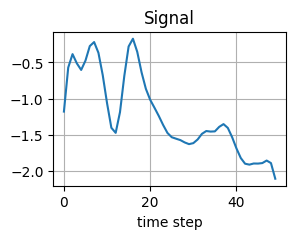

In [4]:
image_width, image_height = 300, 200
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)

inp, out = dataset[0]
imginfo(inp)
ax.plot(inp)
ax.grid(True)
ax.set_title('Signal')
ax.set_xlabel('time step')

## Model

In [5]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from model import LongLSTM

## Train loop

In [6]:
from train import train

@dataclass
class TrainLog:
    train_loss: list = field(default_factory=list)
    eval_loss: list = field(default_factory=list)

In [7]:
# model configuration
input_size = 1  # number of features
hidden_size = 128  # number of features in hidden states
latent_size = 8
num_layers = 1  # number of stacked LSTM layers
output_size = 1  # number of output features

num_epochs = 1000 # 1000
print_val_loss = 50 # 50
batch_size = 1000 # 1000
workers = 1

# Initialize the model
model = LongLSTM(input_size, hidden_size, num_layers, output_size, args.subsample_length, latent_size=latent_size).to(args.DEVICE)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

train_dataset = NeuronDataset(sessions, ttable, args.cue_or_mov)
val_dataset = NeuronDataset(sessions, ttable, args.cue_or_mov, is_validation=True)

train_log = TrainLog()

In [8]:
# epoch 300: 0.1

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
  num_workers=workers, drop_last=False, pin_memory=False)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
  num_workers=workers, drop_last=False, pin_memory=False)

train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, print_val_loss, train_log, args)

Epoch [51/1000], Training_Loss: 0.447750
Epoch [51/1000], Eval_Loss: 0.511
Epoch [101/1000], Training_Loss: 0.249990
Epoch [101/1000], Eval_Loss: 0.261
Epoch [151/1000], Training_Loss: 0.140100
Epoch [151/1000], Eval_Loss: 0.165
Epoch [201/1000], Training_Loss: 0.105664
Epoch [201/1000], Eval_Loss: 0.115
Epoch [251/1000], Training_Loss: 0.098113
Epoch [251/1000], Eval_Loss: 0.107
Epoch [301/1000], Training_Loss: 0.096174
Epoch [301/1000], Eval_Loss: 0.105
Epoch [351/1000], Training_Loss: 0.094530
Epoch [351/1000], Eval_Loss: 0.105
Epoch [401/1000], Training_Loss: 0.090954
Epoch [401/1000], Eval_Loss: 0.101
Epoch [451/1000], Training_Loss: 0.090155
Epoch [451/1000], Eval_Loss: 0.100
Epoch [501/1000], Training_Loss: 0.089499
Epoch [501/1000], Eval_Loss: 0.100
Epoch [551/1000], Training_Loss: 0.088680
Epoch [551/1000], Eval_Loss: 0.099
Epoch [601/1000], Training_Loss: 0.087623
Epoch [601/1000], Eval_Loss: 0.098
Epoch [651/1000], Training_Loss: 0.087177
Epoch [651/1000], Eval_Loss: 0.098
E

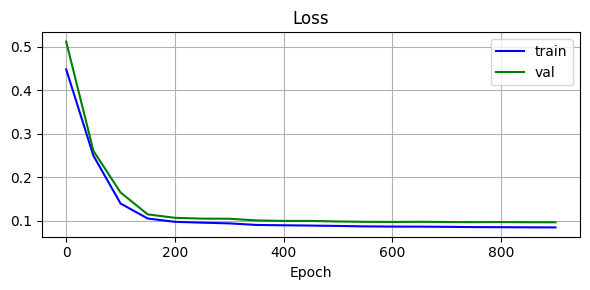

In [9]:
# loss curve

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

x = np.arange(0, num_epochs-print_val_loss, print_val_loss)
ax.plot(x, train_log.train_loss[:len(x)], color='b', label='train')
ax.plot(x, train_log.eval_loss[:len(x)], color='g', label='val')
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.grid(True)
ax.legend()
fig.tight_layout()

fig.savefig("data/loss_curve.png")

## Test example

In [10]:
load_ckpt = True
if load_ckpt:
    model = LongLSTM(input_size, hidden_size, num_layers, output_size, args.subsample_length, latent_size=latent_size)
    model.load_state_dict(torch.load(args.data_dir + f'/best_{model.__class__.__name__}.pth', map_location="cpu"))
    model = model.to(args.DEVICE)
model.eval()

LongLSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (neck_enc): Linear(in_features=256, out_features=8, bias=True)
  (neck_dec): Linear(in_features=8, out_features=256, bias=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

/content/evaluate.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inp, dtype=torch.float).to(args.DEVICE)


Text(0.5, 0, 'time step')

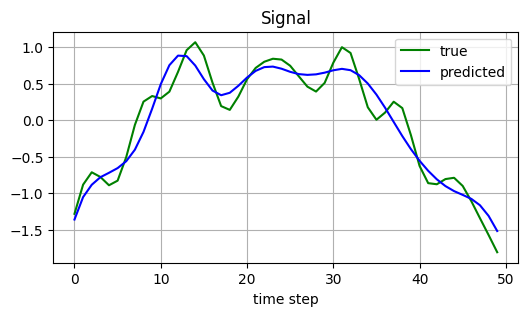

In [11]:
from evaluate import load_sample, predict

model.eval()
session_id, trial_id, neuron_id = 3, 100, 3
sample = load_sample(ttable, session_id, trial_id, neuron_id)
# add batch dimension
pred, latent = predict(model, args, sample[None, :, :])
# remove batch dimension
pred = pred[0]
latent = latent[0]
assert pred.shape[0] == args.subsample_length
assert latent.shape[0] == latent_size

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(sample, color='g', label='true')
ax.plot(pred, color='b', label='predicted')
ax.legend()
ax.grid(True)
ax.set_title('Signal')
ax.set_xlabel('time step')

## Evaluate all and save results

In [12]:
from evaluate import evaluate_and_save
evaluate_and_save(ttable, args, model)

In [13]:
with open(args.data_dir + "/predictions_%s.npy"%args.brain_region, "rb") as f:
    predictions = np.load(f)
    latents = np.load(f)
assert predictions.shape == (len(ttable.precomputed), args.subsample_length)
assert latents.shape == (len(ttable.precomputed), latent_size)

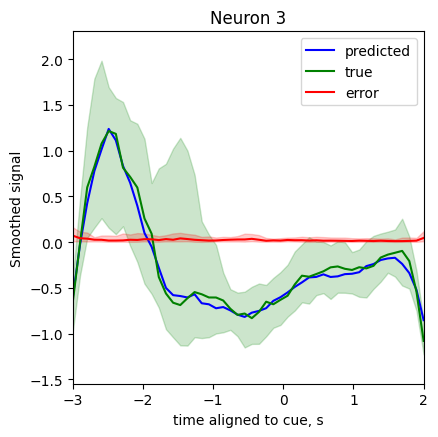

In [14]:
from dataset import get_num_neurons
from evaluate import plot_average
from ipywidgets import widgets, Layout, interact

session_id = 0

# create figure
image_width, image_height = 448, 448
dpi = 100
figsize = (image_width / dpi, image_height / dpi)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
ax.set_axis_off()

interactive = False
if interactive:
    %matplotlib widget
    # slider
    def update(w: int):
        print('neuron', w)
        neuron_id = w
        plot_average(ttable, predictions, args, session_id, neuron_id, fig, ax, target_outcome=1)

    n_neurons = get_num_neurons(sessions, args.cue_or_mov, session_id)
    slider_w = widgets.IntSlider(
        min=0, max=n_neurons-1, step=1, value=0, layout=Layout(width="70%")
    )
    interact(update, w=slider_w)
else:
    plot_average(ttable, predictions, args, session_id, neuron_id, fig, ax, target_outcome=1)

## Intrinsic Dimension

In [27]:
from intrinsic_dimension import intrinsic_dimension_cpu

np.random.seed(0)
Y = np.ones((1000, 10))
X = np.stack([np.random.normal(size=1000) for i in range(10)]).T # (n_feat 10, n_points 1000)
Y[:, :10] = X
print(Y.shape)
assert np.allclose(intrinsic_dimension_cpu(X), 9.195877)

(1000, 10)


In [28]:
from evaluate_id import compute_id_matrix
matrix_0 = compute_id_matrix(sessions, args, ttable, latents, 0)
matrix_1 = compute_id_matrix(sessions, args, ttable, latents, 1)

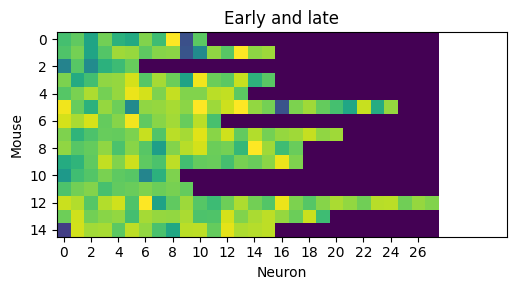

In [29]:
from dataset import get_num_neurons, COL_NEURON
max_neurons = ttable.trial_table[:, COL_NEURON].max()

matrix_01 = (matrix_1 - matrix_0) # negative - blue

fig, ax = plt.subplots(1, 1, figsize=(9, 3))
ax.imshow(matrix_0, vmin=0, vmax=latent_size) # early and late
# ax.imshow(matrix_1, vmin=0, vmax=latent_size) # correct outcomes
# ax.imshow(matrix_01, vmin=-latent_size, vmax=latent_size, cmap="seismic")
ax.set_title("Early and late")
ax.set_xlabel("Neuron")
ax.set_ylabel("Mouse")
ax.set_xticks(np.arange(0, max_neurons, 2), labels=np.arange(0, max_neurons, 2),
              rotation=0, ha="center", rotation_mode="anchor")
ax.set_yticks(np.arange(0, len(sessions), 2), labels=np.arange(0, len(sessions), 2))
ax.set_xlim((-0.5,32.5))

fig.tight_layout()
#fig.savefig("fig.png")

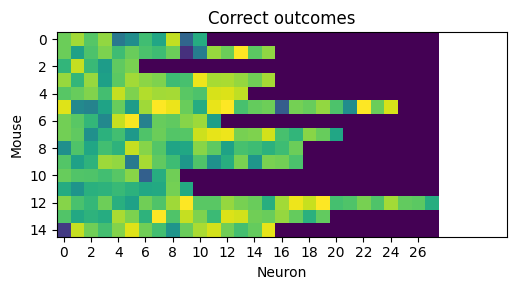

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
# ax.imshow(matrix_0, vmin=0, vmax=latent_size) # early and late
ax.imshow(matrix_1, vmin=0, vmax=latent_size) # correct outcomes
# ax.imshow(matrix_01, vmin=-latent_size, vmax=latent_size, cmap="seismic")
ax.set_title("Correct outcomes")
ax.set_xlabel("Neuron")
ax.set_ylabel("Mouse")
ax.set_xticks(np.arange(0, max_neurons, 2), labels=np.arange(0, max_neurons, 2),
              rotation=0, ha="center", rotation_mode="anchor")
ax.set_yticks(np.arange(0, len(sessions), 2), labels=np.arange(0, len(sessions), 2))
ax.set_xlim((-0.5,32.5))

fig.tight_layout()
#fig.savefig("fig.png")

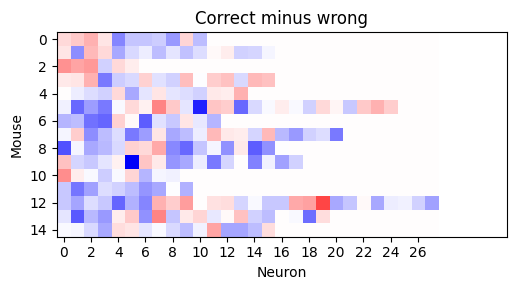

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
# ax.imshow(matrix_0, vmin=0, vmax=latent_size) # early and late
# ax.imshow(matrix_1, vmin=0, vmax=latent_size) # correct outcomes
ax.imshow(matrix_01, vmin=-latent_size, vmax=latent_size, cmap="seismic")
ax.set_title("Correct minus wrong")
ax.set_xlabel("Neuron")
ax.set_ylabel("Mouse")
ax.set_xticks(np.arange(0, max_neurons, 2), labels=np.arange(0, max_neurons, 2),
              rotation=0, ha="center", rotation_mode="anchor")
ax.set_yticks(np.arange(0, len(sessions), 2), labels=np.arange(0, len(sessions), 2))
ax.set_xlim((-0.5,32.5))

fig.tight_layout()
#fig.savefig("fig.png")

In [32]:
eps = 1e-6
e0 = matrix_0[matrix_0 > eps]
print("early and late: %.2f +- %.2f"%(np.mean(e0), np.std(e0)))
e1 = matrix_1[matrix_1 > eps]
print("correct: %.2f +- %.2f"%(np.mean(e1), np.std(e1)))

early and late: 6.31 +- 1.04
correct: 5.93 +- 1.21
